In [1]:
!unzip eyes.zip

Streaming output truncated to the last 5000 lines.
  inflating: eyes/cbd69921-82c7-4367-b6b9-7b90430e4e35.jpeg  
  inflating: eyes/f2c98cfc-7ed9-4eb7-9659-749bb7c7b838.png  
  inflating: eyes/14f2982b-3437-4a89-8f1b-6ab3b2bda218.png  
  inflating: __MACOSX/eyes/._14f2982b-3437-4a89-8f1b-6ab3b2bda218.png  
  inflating: eyes/277c38a4-92e7-4bf7-a176-ade3cdb5e290.png  
  inflating: __MACOSX/eyes/._277c38a4-92e7-4bf7-a176-ade3cdb5e290.png  
  inflating: eyes/564b0e77-e84a-447c-801b-3178b710c793.jpeg  
  inflating: eyes/710d76cd-41f4-4a2d-a4ac-cf587bb018f6.png  
  inflating: eyes/155300dd-ed7e-4da3-aa6e-c077cb9ac762.jpeg  
  inflating: eyes/09e47599-0e71-4021-8208-9d9c9087f14c.jpeg  
  inflating: eyes/b64acd66-9f5c-44ad-bb2c-692f898c500a.jpeg  
  inflating: eyes/715b2d3b-46e1-44b5-aa95-c24abe264444.jpeg  
  inflating: eyes/6ffa870e-95a6-4469-b6eb-c3f26b2f76c6.png  
  inflating: eyes/e063b308-0f2b-499d-bd4f-075da5a11109.png  
  inflating: eyes/740b0acd-b362-41bd-84e5-f7f8095977df.png  
  infl

In [2]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [61]:
# global variables

INPUT_SHAPE_X = 128
INPUT_SHAPE_Y = 64
ITERATION = '7'
EPOCHS = 1000
BATCH_SIZE = 8

max_images = 1800 #2054 # max images per class

In [4]:
# load labels
csv_path = 'labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [49]:
# load the images
eyes_path = 'eyes'
eyes_dir = os.listdir(eyes_path)
x_eyes = []
y_eyes = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in eyes_dir:
    # load the image
    image_path = os.path.join(eyes_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # preprocess the image
    if (img is not None):
    
        # check image class
        image_class = labels.loc[labels['imageid'] == image, 'orbital_tightening']

        if not image_class.empty:
            image_class = image_class.iloc[0]    
            
            # append an equal number of images from each class
            if (image_class == 0.0 and class_0 < max_images):
                x_eyes.append(img)
                y_eyes.append(image_class)
                class_0 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 1.0 and class_1 < max_images-200):
                x_eyes.append(img)
                y_eyes.append(image_class)
                class_1 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 2.0 and class_2 < max_images):
                x_eyes.append(img)
                y_eyes.append(image_class)
                class_2 += 1
                if (i == max_images*3):
                    break
                i+=1
  


In [50]:
# add flipped images from class 2
flipped_path = 'eyes-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_eyes.append(img)
    y_eyes.append(2)
    class_2 += 1

In [51]:
# add augmented images from class 2
aug_path = 'eyes-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_eyes.append(img)
    y_eyes.append(2)
    class_2 += 1

In [52]:
print(class_0, class_1, class_2)

1800 1600 1360


In [53]:
# preprocess
x_eyes = tf.keras.applications.vgg16.preprocess_input(np.array(x_eyes))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_eyes, y_eyes, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

In [58]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [59]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=10)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 2, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 4096)              0         
                                                                 
 dense_20 (Dense)            (None, 256)               1048832   
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 dense_21 (Dense)            (None, 256)               65792     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 dense_22 (Dense)            (None, 128)              

In [62]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs=EPOCHS,
              batch_size=BATCH_SIZE, 
              validation_data=(x_val, y_val),
              callbacks=[earlystop])

Epoch 1/1000
381/381 [==============================] - 14s 38ms/step - loss: 0.3997 - accuracy: 0.8411 - val_loss: 0.9994 - val_accuracy: 0.6155
Epoch 2/1000
381/381 [==============================] - 14s 38ms/step - loss: 0.3323 - accuracy: 0.8677 - val_loss: 1.2477 - val_accuracy: 0.5906
Epoch 3/1000
381/381 [==============================] - 14s 38ms/step - loss: 0.2854 - accuracy: 0.8995 - val_loss: 1.0305 - val_accuracy: 0.6457
Epoch 4/1000
381/381 [==============================] - 15s 38ms/step - loss: 0.2287 - accuracy: 0.9107 - val_loss: 1.3688 - val_accuracy: 0.6010
Epoch 5/1000
381/381 [==============================] - 14s 38ms/step - loss: 0.2062 - accuracy: 0.9297 - val_loss: 1.2783 - val_accuracy: 0.6417
Epoch 6/1000
381/381 [==============================] - 14s 38ms/step - loss: 0.1718 - accuracy: 0.9517 - val_loss: 1.1762 - val_accuracy: 0.6575
Epoch 7/1000
381/381 [==============================] - 15s 38ms/step - loss: 0.1346 - accuracy: 0.9619 - val_loss: 1.1560 -

In [64]:
# save the model and training history
path = 'model_' + ITERATION
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'eyes_history_' + ITERATION +'.csv'
history_df.to_csv(path, index=False)

In [63]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

30/30 [==============================] - 1s 24ms/step - loss: 1.7994 - accuracy: 0.6859
[1.7993581295013428, 0.6859243512153625]


In [65]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

30/30 [==============================] - 1s 23ms/step


In [66]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report - eyes\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.69


Classification Report - eyes

              precision    recall  f1-score   support

     Score 0       0.72      0.68      0.70       363
     Score 1       0.58      0.59      0.58       317
     Score 2       0.77      0.81      0.79       272

   micro avg       0.69      0.69      0.69       952
   macro avg       0.69      0.69      0.69       952
weighted avg       0.69      0.69      0.69       952
 samples avg       0.69      0.69      0.69       952



Confusion Matrix

[[248  91  24]
 [ 90 186  41]
 [  7  46 219]]


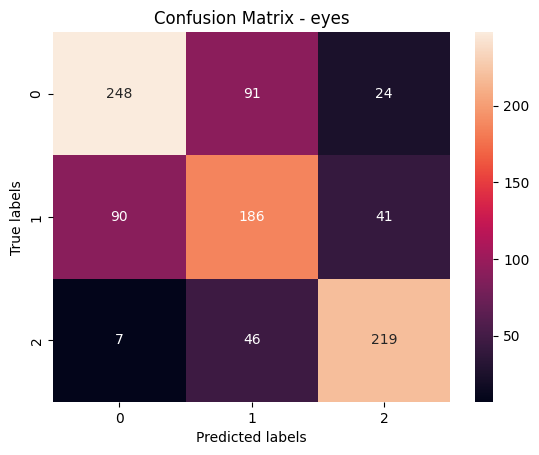

In [67]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - eyes'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()

In [68]:
!zip -r model_7.zip model_7

  adding: model_7/ (stored 0%)
  adding: model_7/assets/ (stored 0%)
  adding: model_7/keras_metadata.pb (deflated 96%)
  adding: model_7/fingerprint.pb (stored 0%)
  adding: model_7/variables/ (stored 0%)
  adding: model_7/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: model_7/variables/variables.index (deflated 69%)
  adding: model_7/saved_model.pb (deflated 90%)
